In [111]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
train_x1 = torch.linspace(0, 0.95, 25) + 0.05 * torch.rand(25)
train_x2 = torch.linspace(0, 0.95, 25) + 0.05 * torch.rand(25)

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x1)
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x2)

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module, mean_module):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

shared_mean = gpytorch.means.ConstantMean()

shared_kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

shared_likelihood = gpytorch.likelihoods.GaussianLikelihood()

model1 = ExactGPModel(
    train_x1, train_y1,
    shared_likelihood,
    shared_kernel,
    shared_mean,
)

model2 = ExactGPModel(
    train_x2, train_y2,
    shared_likelihood,
    shared_kernel,
    shared_mean,
)
#FROM TUTORIAL
# likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
# model1 = ExactGPModel(train_x1, train_y1, likelihood1)

# likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
# model2 = ExactGPModel(train_x2, train_y2, likelihood2)

In [114]:
model = gpytorch.models.IndependentModelList(model1, model2)
likelihood = gpytorch.likelihoods.LikelihoodList(shared_likelihood, shared_likelihood)

In [115]:
from gpytorch.mlls import SumMarginalLogLikelihood

mll = SumMarginalLogLikelihood(likelihood, model)

In [116]:


# -----------------------------
# Training
# -----------------------------
model.train()
likelihood.train()

optimizer = torch.optim.Adam(
    [
        {"params": model.parameters()},           ],
    lr=0.1,
)

print("=== Parameters seen by model.parameters() ===")
for name, p in model.named_parameters():
    print(name)

training_iterations = 50

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    optimizer.step()

    if (i + 1) % 10 == 0:
        print(f"Iter {i+1}/{training_iterations} - Loss: {loss.item():.3f}")

# -----------------------------
# Parameter inspection
# -----------------------------
print("\n=== Parameter values per GP ===")

for i, m in enumerate(model.models):
    print(f"\nGP {i}")
    print("  lengthscale :", m.covar_module.base_kernel.lengthscale.item())
    print("  outputscale :", m.covar_module.outputscale.item())
    print("  noise       :", m.likelihood.noise.item())
    print("  mean        :", m.mean_module.constant.item())

# # Use the Adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# #todo, check noise is actually included
# for i in range(training_iterations):
#     optimizer.zero_grad()
#     output = model(*model.train_inputs)
#     loss = -mll(output, model.train_targets)
#     loss.backward()
#     print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
#     optimizer.step()



=== Parameters seen by model.parameters() ===
models.0.likelihood.noise_covar.raw_noise
models.0.mean_module.raw_constant
models.0.covar_module.raw_lengthscale
Iter 10/50 - Loss: 0.717
Iter 20/50 - Loss: 0.409
Iter 30/50 - Loss: 0.193
Iter 40/50 - Loss: 0.184
Iter 50/50 - Loss: 0.177

=== Parameter values per GP ===

GP 0


AttributeError: 'RBFKernel' object has no attribute 'base_kernel'

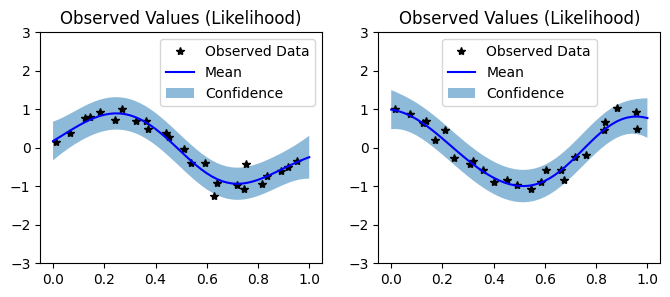

In [104]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions (use the same test points)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    # This contains predictions for both outcomes as a list
    predictions = likelihood(*model(test_x, test_x))

for submodel, prediction, ax in zip(model.models, predictions, axs):
    mean = prediction.mean
    lower, upper = prediction.confidence_region()

    tr_x = submodel.train_inputs[0].detach().numpy()
    tr_y = submodel.train_targets.detach().numpy()

    # Plot training data as black stars
    ax.plot(tr_x, tr_y, 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title('Observed Values (Likelihood)')

None

In [ ]:
## Batching code does not work rn 

In [80]:
#batched case, for same X's 
train_x_batch = train_x1

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x1)
train_y2 = torch.cos(train_x1 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x1)

train_y_batch = torch.stack([train_y1, train_y2], dim = 0)

In [81]:
class SharedParamBatchGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        # train_x: (N, D)
        # train_y: (2, N)  <-- NOTICE: Batch dim is 0
        super().__init__(train_x, train_y, likelihood)
        
        # Setting batch_shape=[] ensures ONLY 1 set of params is created
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([])),
            batch_shape=torch.Size([])
        )

    def forward(self, x):
        # When we pass x (N, D), the modules (batch_shape=[]) produce (N) and (N,N)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        # This is the standard MVN. Because train_y is (2, N), 
        # GPyTorch knows this model needs to handle 2 batches.
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# 2. Use a standard Likelihood (shared noise)
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([]))

model = SharedParamBatchGP(train_x_batch, train_y_batch, likelihood)

In [ ]:
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x_batch)
    loss = -mll(output, train_y_batch)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter  1/50 - Loss: 2.146 | LS: 0.6444 | OS: 0.7444 | Noise: 0.6445 | Mean: 0.1000
Iter  5/50 - Loss: 1.853 | LS: 0.4738 | OS: 0.9714 | Noise: 0.4735 | Mean: 0.4635
Iter 10/50 - Loss: 1.420 | LS: 0.3132 | OS: 1.2912 | Noise: 0.3097 | Mean: 0.5075
Iter 15/50 - Loss: 1.099 | LS: 0.2391 | OS: 1.3361 | Noise: 0.1952 | Mean: 0.2081
Iter 20/50 - Loss: 0.778 | LS: 0.2467 | OS: 1.0999 | Noise: 0.1206 | Mean: -0.0047
Iter 25/50 - Loss: 0.478 | LS: 0.2891 | OS: 0.8393 | Noise: 0.0746 | Mean: 0.1223
Iter 30/50 - Loss: 0.302 | LS: 0.2946 | OS: 0.7317 | Noise: 0.0474 | Mean: 0.3353
Iter 35/50 - Loss: 0.216 | LS: 0.2632 | OS: 0.7699 | Noise: 0.0325 | Mean: 0.2796
Iter 40/50 - Loss: 0.229 | LS: 0.2570 | OS: 0.8011 | Noise: 0.0255 | Mean: 0.1187
Iter 45/50 - Loss: 0.247 | LS: 0.2731 | OS: 0.8036 | Noise: 0.0238 | Mean: 0.1607
Iter 50/50 - Loss: 0.235 | LS: 0.2833 | OS: 0.8387 | Noise: 0.0255 | Mean: 0.2793


In [85]:
import matplotlib.pyplot as plt

# ---- DIAGNOSTICS (NOW VALID) ----
print("train_x_batch:", train_x_batch.shape)
print("train_y_batch:", train_y_batch.shape)
#print("pred_mean:", pred_mean.shape)
print("lower:", lower.shape)
print("upper:", upper.shape)

model.eval()
likelihood.eval()

Q = train_y_batch.size(0)

with torch.no_grad():
    predictions = likelihood(model(train_x_batch))
    pred_mean = predictions.mean                 # [Q, N]
    lower, upper = predictions.confidence_region()



assert train_x_batch.shape == (25,)
assert train_y_batch.shape == pred_mean.shape
assert lower.shape == pred_mean.shape
assert upper.shape == pred_mean.shape

# ---- PLOTTING ----
fig, axs = plt.subplots(1, Q, figsize=(5 * Q, 4))

tr_x = train_x_batch.detach().cpu().numpy()
sort_idx = tr_x.argsort()

for i in range(Q):
    ax = axs[i] if Q > 1 else axs

    tr_y = train_y_batch[i].detach().cpu().numpy()

    ax.plot(tr_x, tr_y, 'k*', label='Observed Data')

    ax.plot(
        tr_x[sort_idx],
        pred_mean[i, sort_idx].cpu().numpy(),
        'b',
        label='Mean Fit'
    )

    ax.fill_between(
        tr_x[sort_idx],
        lower[i, sort_idx].cpu().numpy(),
        upper[i, sort_idx].cpu().numpy(),
        alpha=0.3,
        label='Confidence'
    )

    ax.set_ylim([-3, 3])
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ls_val = model.covar_module.base_kernel.lengthscale.item()
    ax.set_title(f'Query {i+1} (Shared LS: {ls_val:.2f})')
    ax.legend()

plt.tight_layout()
plt.show()


train_x_batch: torch.Size([25])
train_y_batch: torch.Size([2, 25])
lower: torch.Size([25])
upper: torch.Size([25])


RuntimeError: shape '[25]' is invalid for input of size 50